# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [25]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

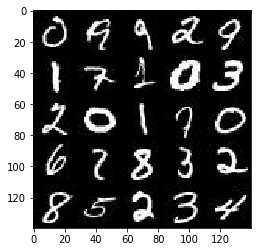

In [26]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

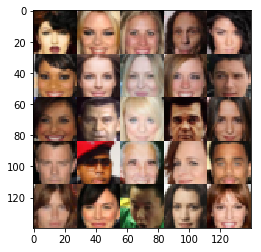

In [27]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [49]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [50]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):        
        alpha = 0.1          
        
        h1 = tf.layers.conv2d(inputs=images,
                              filters=64,
                              kernel_size=5,
                              strides=2,
                              padding='same')
        h1 = tf.nn.dropout(h1, 0.3)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(inputs=h1,
                              filters=128,
                              kernel_size=5,
                              strides=2,
                              padding='same')
        h2 = tf.nn.dropout(h2, 0.3)
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(inputs=h2,
                              filters=256,
                              kernel_size=5,
                              strides=2,
                              padding='same')
        h3 = tf.nn.dropout(h3, 0.3)
        h3 = tf.layers.batch_normalization(inputs=h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [52]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        
        fcl = tf.layers.dense(z, 2 * 2 * 512)
        
        c1 = tf.reshape(fcl, (-1, 2, 2, 512))
        batch_norm1 = tf.layers.batch_normalization(inputs=c1,
                                                    training=is_train)
        relu1 = tf.maximum(alpha * c1, c1)
        
        c2 = tf.layers.conv2d_transpose(inputs=c1,
                                        filters=256,
                                        kernel_size=3,
                                        strides=2,
                                        padding='same')
        c2 = tf.layers.dropout(c2, 0.5, training = True)
            
        batch_norm2 = tf.layers.batch_normalization(inputs=c2,
                                                    training=is_train)
        relu2 = tf.maximum(alpha * c2, c2)
        
        c3 = tf.layers.conv2d_transpose(inputs=c2,
                                        filters=128,
                                        kernel_size=4,
                                        strides=1,
                                        padding='valid')
        c3 = tf.layers.dropout(c3, 0.5, training = True)
        
        batch_norm3 = tf.layers.batch_normalization(inputs=c3, 
                                                    training=is_train)
        relu3 = tf.maximum(alpha * c3, c3)
        
        c4 = tf.layers.conv2d_transpose(inputs=c3,
                                        filters=64,
                                        kernel_size=3,
                                        strides=2,
                                        padding='same')
        
        c4 = tf.layers.dropout(c4, 0.5, training = True)
        batch_norm4 = tf.layers.batch_normalization(inputs=c4,
                                                    training=is_train)
        relu4 = tf.maximum(alpha * c4, c4)
        
        logits = tf.layers.conv2d_transpose(inputs=c4,
                                            filters=out_channel_dim,
                                            kernel_size=5,
                                            strides=2,
                                            padding='same')
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen = generator(input_z, out_channel_dim, is_train=True)
    real_disc, real_logits = discriminator(input_real)
    false_disc, false_logits = discriminator(gen, reuse=True)
    
    real_tensor = tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits,
                                                          labels=tf.ones_like(real_logits))
    real_loss = tf.reduce_mean(real_tensor)
    
    false_tensor = tf.nn.sigmoid_cross_entropy_with_logits(logits=false_logits,
                                                           labels=tf.zeros_like(false_logits))
    false_loss = tf.reduce_mean(false_tensor)
    disc_loss = real_loss + false_loss

    loss_tensor = tf.nn.sigmoid_cross_entropy_with_logits(logits=false_logits,
                                                          labels=tf.ones_like(false_logits))
    
    gen_loss = tf.reduce_mean(loss_tensor)
    
    return disc_loss, gen_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    v_train = tf.trainable_variables()
    v_disc = [v for v in v_train if v.name.startswith('discriminator')]
    v_gen = [v for v in v_train if v.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        opt_disc = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=v_disc)

    with tf.control_dependencies(g_updates):
        opt_gen = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=v_gen)
            
    return opt_disc, opt_gen


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [54]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=20
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=data_shape[3])    
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=learning_rate, beta1=beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

SyntaxError: invalid syntax (<ipython-input-54-170b0181d6be>, line 13)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7357... Generator Loss: 1.2777
Epoch 1/2... Discriminator Loss: 0.3683... Generator Loss: 2.0669
Epoch 1/2... Discriminator Loss: 0.2260... Generator Loss: 2.7397
Epoch 1/2... Discriminator Loss: 0.2344... Generator Loss: 2.8470
Epoch 1/2... Discriminator Loss: 0.3736... Generator Loss: 2.1855
Epoch 1/2... Discriminator Loss: 0.2006... Generator Loss: 3.2531
Epoch 1/2... Discriminator Loss: 0.6349... Generator Loss: 1.2716
Epoch 1/2... Discriminator Loss: 0.2618... Generator Loss: 2.6792
Epoch 1/2... Discriminator Loss: 0.4201... Generator Loss: 3.0354
Epoch 1/2... Discriminator Loss: 0.5678... Generator Loss: 1.7949


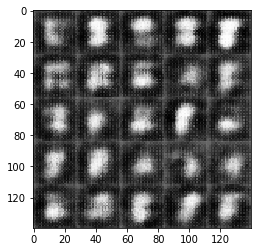

Epoch 1/2... Discriminator Loss: 0.2347... Generator Loss: 3.1473
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.4547
Epoch 1/2... Discriminator Loss: 0.3632... Generator Loss: 3.1739
Epoch 1/2... Discriminator Loss: 0.7492... Generator Loss: 2.1504
Epoch 1/2... Discriminator Loss: 0.7268... Generator Loss: 1.8597
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 1.9757
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 1.3924
Epoch 1/2... Discriminator Loss: 0.7826... Generator Loss: 2.2124
Epoch 1/2... Discriminator Loss: 0.6268... Generator Loss: 2.8748
Epoch 1/2... Discriminator Loss: 0.3205... Generator Loss: 2.9537


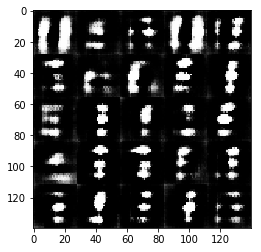

Epoch 1/2... Discriminator Loss: 0.4434... Generator Loss: 2.6617
Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 2.8202
Epoch 1/2... Discriminator Loss: 0.4250... Generator Loss: 2.3810
Epoch 1/2... Discriminator Loss: 0.5710... Generator Loss: 3.4981
Epoch 1/2... Discriminator Loss: 0.4794... Generator Loss: 3.1954
Epoch 1/2... Discriminator Loss: 0.4794... Generator Loss: 2.0934
Epoch 1/2... Discriminator Loss: 0.2772... Generator Loss: 3.5772
Epoch 1/2... Discriminator Loss: 0.5200... Generator Loss: 3.0187
Epoch 1/2... Discriminator Loss: 0.5748... Generator Loss: 2.0074
Epoch 1/2... Discriminator Loss: 0.5954... Generator Loss: 3.0995


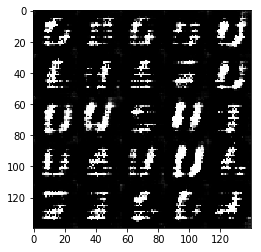

Epoch 1/2... Discriminator Loss: 0.4478... Generator Loss: 2.7218
Epoch 1/2... Discriminator Loss: 0.5651... Generator Loss: 2.3211
Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 1.3614
Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 1.9894
Epoch 1/2... Discriminator Loss: 0.2743... Generator Loss: 2.9518
Epoch 1/2... Discriminator Loss: 0.3638... Generator Loss: 3.4657
Epoch 1/2... Discriminator Loss: 0.6310... Generator Loss: 3.3563
Epoch 1/2... Discriminator Loss: 0.5794... Generator Loss: 1.9221
Epoch 1/2... Discriminator Loss: 1.0965... Generator Loss: 2.4880
Epoch 1/2... Discriminator Loss: 0.5570... Generator Loss: 2.1516


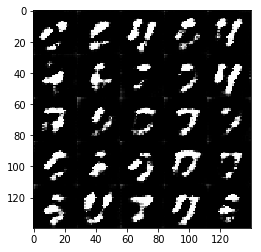

Epoch 1/2... Discriminator Loss: 0.4814... Generator Loss: 1.7190
Epoch 1/2... Discriminator Loss: 0.2727... Generator Loss: 2.0114
Epoch 1/2... Discriminator Loss: 0.4654... Generator Loss: 2.7072
Epoch 1/2... Discriminator Loss: 0.5039... Generator Loss: 2.0230
Epoch 1/2... Discriminator Loss: 0.4889... Generator Loss: 3.7883
Epoch 1/2... Discriminator Loss: 0.4800... Generator Loss: 2.2980
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 2.9537
Epoch 1/2... Discriminator Loss: 0.5361... Generator Loss: 2.2947
Epoch 1/2... Discriminator Loss: 0.6441... Generator Loss: 3.0556
Epoch 1/2... Discriminator Loss: 0.7540... Generator Loss: 1.7568


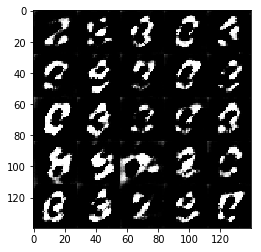

Epoch 1/2... Discriminator Loss: 0.5391... Generator Loss: 2.8526
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 1.9263
Epoch 1/2... Discriminator Loss: 0.3907... Generator Loss: 3.1688
Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 1.6542
Epoch 1/2... Discriminator Loss: 0.3617... Generator Loss: 3.2803
Epoch 1/2... Discriminator Loss: 0.4670... Generator Loss: 2.7042
Epoch 1/2... Discriminator Loss: 0.4674... Generator Loss: 2.4122
Epoch 1/2... Discriminator Loss: 0.5095... Generator Loss: 2.9333
Epoch 1/2... Discriminator Loss: 0.4229... Generator Loss: 3.2556
Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 3.8619


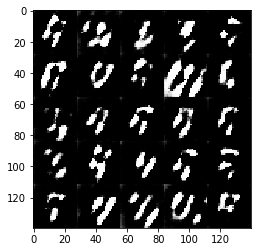

Epoch 1/2... Discriminator Loss: 0.3104... Generator Loss: 3.0518
Epoch 1/2... Discriminator Loss: 0.3165... Generator Loss: 2.2699
Epoch 1/2... Discriminator Loss: 0.2603... Generator Loss: 4.5725
Epoch 1/2... Discriminator Loss: 0.4212... Generator Loss: 4.3140
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 2.0236
Epoch 1/2... Discriminator Loss: 0.2964... Generator Loss: 2.6099
Epoch 1/2... Discriminator Loss: 0.2295... Generator Loss: 3.2617
Epoch 1/2... Discriminator Loss: 0.3391... Generator Loss: 1.5174
Epoch 1/2... Discriminator Loss: 0.4365... Generator Loss: 3.7860
Epoch 1/2... Discriminator Loss: 0.4181... Generator Loss: 2.6323


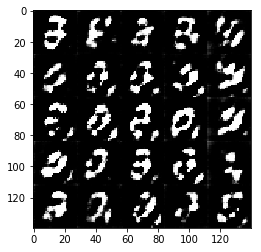

Epoch 1/2... Discriminator Loss: 0.4297... Generator Loss: 3.0724
Epoch 1/2... Discriminator Loss: 0.2979... Generator Loss: 3.5305
Epoch 1/2... Discriminator Loss: 0.3246... Generator Loss: 2.6856
Epoch 1/2... Discriminator Loss: 0.3963... Generator Loss: 3.3087
Epoch 1/2... Discriminator Loss: 0.3696... Generator Loss: 2.5299
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 2.7732
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 3.1643
Epoch 1/2... Discriminator Loss: 0.4329... Generator Loss: 2.3507
Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 2.0017
Epoch 1/2... Discriminator Loss: 0.7465... Generator Loss: 3.2445


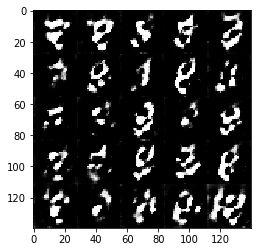

Epoch 1/2... Discriminator Loss: 0.3819... Generator Loss: 2.5770
Epoch 1/2... Discriminator Loss: 0.3897... Generator Loss: 2.9742
Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 2.0010
Epoch 1/2... Discriminator Loss: 0.7243... Generator Loss: 2.3397
Epoch 1/2... Discriminator Loss: 0.6112... Generator Loss: 2.2890
Epoch 1/2... Discriminator Loss: 0.4511... Generator Loss: 2.7284
Epoch 1/2... Discriminator Loss: 0.7588... Generator Loss: 3.1517
Epoch 1/2... Discriminator Loss: 0.2890... Generator Loss: 2.7309
Epoch 1/2... Discriminator Loss: 0.7073... Generator Loss: 2.8937
Epoch 1/2... Discriminator Loss: 0.6833... Generator Loss: 2.7373


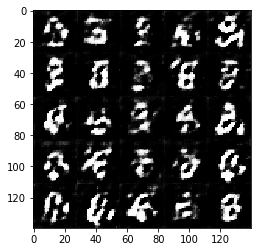

Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 2.8384
Epoch 1/2... Discriminator Loss: 0.9787... Generator Loss: 2.5529
Epoch 1/2... Discriminator Loss: 1.5397... Generator Loss: 3.3606
Epoch 2/2... Discriminator Loss: 0.7508... Generator Loss: 2.5095
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 2.6768
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.6818
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 2.9497
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 2.1914
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 2.1724
Epoch 2/2... Discriminator Loss: 0.7286... Generator Loss: 1.5727


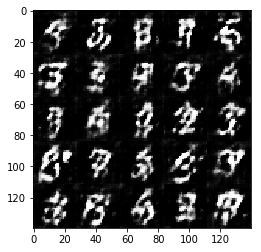

Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 2.6627
Epoch 2/2... Discriminator Loss: 0.7681... Generator Loss: 1.4857
Epoch 2/2... Discriminator Loss: 1.4684... Generator Loss: 0.6346
Epoch 2/2... Discriminator Loss: 0.5459... Generator Loss: 2.3866
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 2.4271
Epoch 2/2... Discriminator Loss: 0.7068... Generator Loss: 2.4168
Epoch 2/2... Discriminator Loss: 0.4633... Generator Loss: 1.8029
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 2.2544
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.4878
Epoch 2/2... Discriminator Loss: 0.5132... Generator Loss: 1.8749


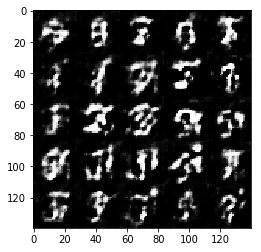

Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 3.2136
Epoch 2/2... Discriminator Loss: 1.0615... Generator Loss: 0.9162
Epoch 2/2... Discriminator Loss: 0.6552... Generator Loss: 1.4031
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 2.0412
Epoch 2/2... Discriminator Loss: 0.9221... Generator Loss: 2.7743
Epoch 2/2... Discriminator Loss: 0.6443... Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 0.4956... Generator Loss: 2.5936
Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 1.7622
Epoch 2/2... Discriminator Loss: 0.7510... Generator Loss: 2.5865
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 1.0165


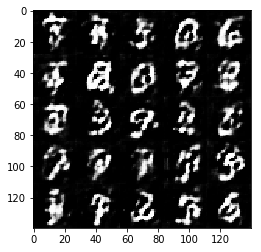

Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 1.8414
Epoch 2/2... Discriminator Loss: 0.4066... Generator Loss: 2.8275
Epoch 2/2... Discriminator Loss: 0.6362... Generator Loss: 1.3421
Epoch 2/2... Discriminator Loss: 0.5158... Generator Loss: 1.8675
Epoch 2/2... Discriminator Loss: 0.5732... Generator Loss: 2.1605
Epoch 2/2... Discriminator Loss: 0.6438... Generator Loss: 3.8047
Epoch 2/2... Discriminator Loss: 0.4035... Generator Loss: 2.9626
Epoch 2/2... Discriminator Loss: 0.5949... Generator Loss: 1.2206
Epoch 2/2... Discriminator Loss: 0.5050... Generator Loss: 1.6079
Epoch 2/2... Discriminator Loss: 0.7325... Generator Loss: 1.1866


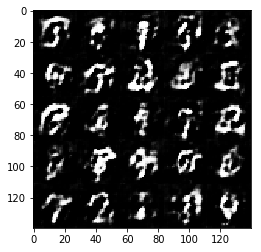

Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 1.9787
Epoch 2/2... Discriminator Loss: 0.8144... Generator Loss: 1.7434
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 3.9873
Epoch 2/2... Discriminator Loss: 0.4871... Generator Loss: 2.3357
Epoch 2/2... Discriminator Loss: 0.9679... Generator Loss: 3.9980
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 2.8055
Epoch 2/2... Discriminator Loss: 0.8337... Generator Loss: 1.6337
Epoch 2/2... Discriminator Loss: 0.3911... Generator Loss: 2.6059
Epoch 2/2... Discriminator Loss: 0.4533... Generator Loss: 2.0593
Epoch 2/2... Discriminator Loss: 0.3787... Generator Loss: 2.1795


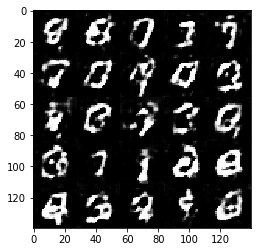

Epoch 2/2... Discriminator Loss: 0.6441... Generator Loss: 4.6505
Epoch 2/2... Discriminator Loss: 0.5065... Generator Loss: 2.7014
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 2.7832
Epoch 2/2... Discriminator Loss: 0.6025... Generator Loss: 1.1586
Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 1.6034
Epoch 2/2... Discriminator Loss: 0.4969... Generator Loss: 2.9795
Epoch 2/2... Discriminator Loss: 0.5264... Generator Loss: 2.1468
Epoch 2/2... Discriminator Loss: 0.6862... Generator Loss: 3.4223
Epoch 2/2... Discriminator Loss: 0.4904... Generator Loss: 1.3831
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 1.4380


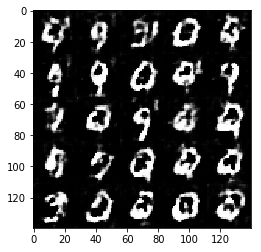

Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 1.6248
Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 2.1367
Epoch 2/2... Discriminator Loss: 0.3279... Generator Loss: 3.3621
Epoch 2/2... Discriminator Loss: 0.3220... Generator Loss: 2.3122
Epoch 2/2... Discriminator Loss: 0.3292... Generator Loss: 3.0566
Epoch 2/2... Discriminator Loss: 0.4375... Generator Loss: 2.9307
Epoch 2/2... Discriminator Loss: 0.3669... Generator Loss: 3.6536
Epoch 2/2... Discriminator Loss: 0.2291... Generator Loss: 3.5210
Epoch 2/2... Discriminator Loss: 0.4294... Generator Loss: 3.4897
Epoch 2/2... Discriminator Loss: 0.6859... Generator Loss: 1.4875


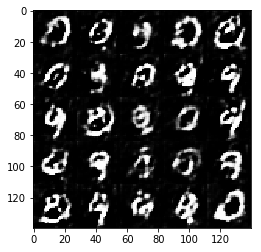

Epoch 2/2... Discriminator Loss: 0.4280... Generator Loss: 3.9691
Epoch 2/2... Discriminator Loss: 0.3293... Generator Loss: 3.7139
Epoch 2/2... Discriminator Loss: 0.3635... Generator Loss: 2.6515
Epoch 2/2... Discriminator Loss: 0.2457... Generator Loss: 3.3764
Epoch 2/2... Discriminator Loss: 0.4584... Generator Loss: 3.4338
Epoch 2/2... Discriminator Loss: 0.2866... Generator Loss: 2.4260
Epoch 2/2... Discriminator Loss: 0.3609... Generator Loss: 2.1943
Epoch 2/2... Discriminator Loss: 0.2860... Generator Loss: 4.7095
Epoch 2/2... Discriminator Loss: 0.3980... Generator Loss: 2.5142
Epoch 2/2... Discriminator Loss: 0.2027... Generator Loss: 2.1807


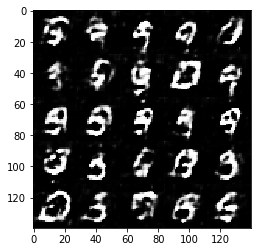

Epoch 2/2... Discriminator Loss: 0.2613... Generator Loss: 3.1218
Epoch 2/2... Discriminator Loss: 0.4759... Generator Loss: 2.8405
Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 2.9847
Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 4.4416
Epoch 2/2... Discriminator Loss: 0.2011... Generator Loss: 3.9265
Epoch 2/2... Discriminator Loss: 0.2914... Generator Loss: 3.6527
Epoch 2/2... Discriminator Loss: 0.2574... Generator Loss: 3.3992
Epoch 2/2... Discriminator Loss: 0.2348... Generator Loss: 4.0809
Epoch 2/2... Discriminator Loss: 0.2220... Generator Loss: 3.2692
Epoch 2/2... Discriminator Loss: 0.2260... Generator Loss: 4.1696


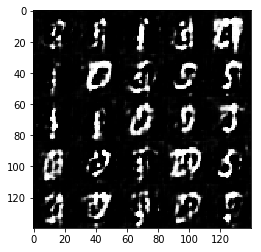

Epoch 2/2... Discriminator Loss: 0.1980... Generator Loss: 3.4150
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 5.4802
Epoch 2/2... Discriminator Loss: 0.2516... Generator Loss: 2.7298
Epoch 2/2... Discriminator Loss: 0.5113... Generator Loss: 5.2574
Epoch 2/2... Discriminator Loss: 0.3322... Generator Loss: 1.7996
Epoch 2/2... Discriminator Loss: 0.1977... Generator Loss: 2.6907
Epoch 2/2... Discriminator Loss: 0.2159... Generator Loss: 3.4537


In [53]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 2.0927
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.7372
Epoch 1/1... Discriminator Loss: 2.6937... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 4.0749... Generator Loss: 0.0480
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 2.0695
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 3.3583
Epoch 1/1... Discriminator Loss: 4.3992... Generator Loss: 5.5624
Epoch 1/1... Discriminator Loss: 2.7103... Generator Loss: 5.3051
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 2.5654
Epoch 1/1... Discriminator Loss: 5.6092... Generator Loss: 0.0099


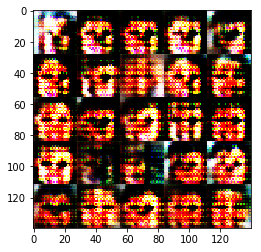

Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.5280
Epoch 1/1... Discriminator Loss: 0.4749... Generator Loss: 1.4712
Epoch 1/1... Discriminator Loss: 3.8366... Generator Loss: 0.0368
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 3.4903... Generator Loss: 0.2289
Epoch 1/1... Discriminator Loss: 0.4814... Generator Loss: 1.4429
Epoch 1/1... Discriminator Loss: 0.1952... Generator Loss: 1.9955
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 2.4439... Generator Loss: 4.5484
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.4152


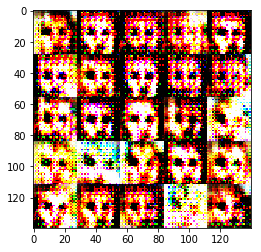

Epoch 1/1... Discriminator Loss: 0.1731... Generator Loss: 2.2177
Epoch 1/1... Discriminator Loss: 0.0692... Generator Loss: 3.1230
Epoch 1/1... Discriminator Loss: 0.0452... Generator Loss: 3.7796
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 5.6818
Epoch 1/1... Discriminator Loss: 0.0161... Generator Loss: 5.0121
Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 5.1639
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 5.8087
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 5.6428
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 5.7830
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 6.0965


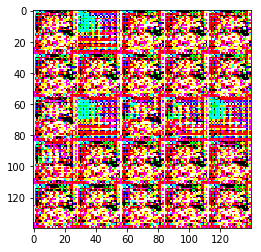

Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 6.1539
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 6.4699
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 6.6976
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 6.9543
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 6.7303
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 6.8466
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 6.6782
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 6.8809
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 6.6072
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 7.1522


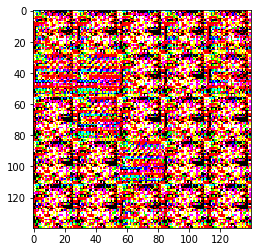

Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 7.1776
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.9937
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.2915
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.3825
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 7.1573
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 7.5606
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.7055
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.6257
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.2422
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.7601


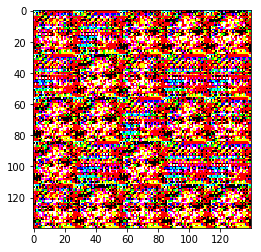

Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 7.8973
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 8.3397
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.6402
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.2905
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.2647
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.5751
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.8652
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.5499
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.5541
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 8.5392


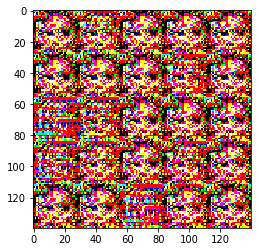

Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.8885
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 8.7101
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.7885
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.7170
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.6264
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.6084
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.8918
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.8867
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.0499
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.9008


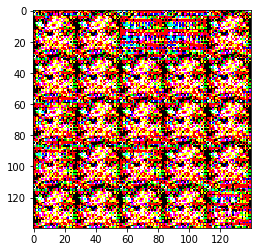

Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.0247
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.3794
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.1891
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.1272
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.8644
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 9.1092
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.9214
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.2126
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.2006
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.9840


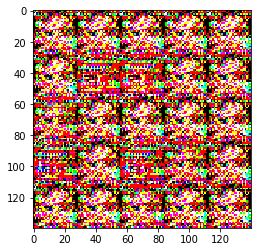

Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 9.2983
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.0945
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.1020
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.0856
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.0495
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.5058
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.3269
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.3427
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.4269
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.1361


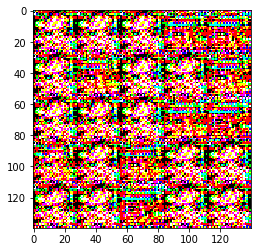

Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.2928
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.0833
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.4720
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.5129
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.0147
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.1686
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.2589
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.7430
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.7910
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 9.2725


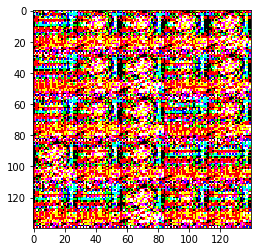

Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.2701
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 10.1548
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 10.1254
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 9.9497
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 10.6443
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 10.4708
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 10.4381
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 11.3972
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 10.6748
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 10.5119


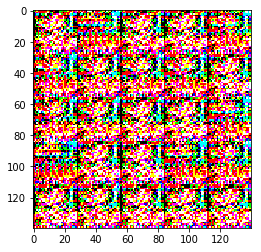

Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 10.6086
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 11.4227
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 11.0056
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 10.7941
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 10.8431
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 11.3530
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.1937
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.4316
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 11.7951
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.3171


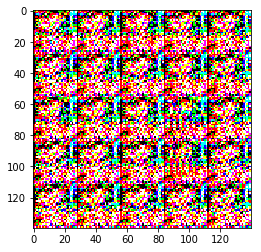

Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.3188
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.2341
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.3568
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 11.5558
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 11.8221
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.4299
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.4662
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.3146
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 11.8880
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 11.5934


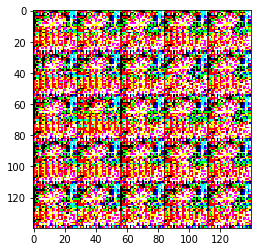

Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.3064
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.0590
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.1754
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.1913
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.1031
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.5364
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.4441
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.4322
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 12.3242
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 13.2706


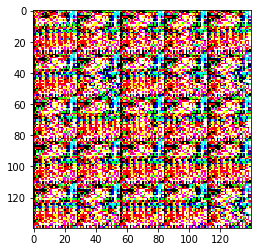

Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.4815
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.1925
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.4625
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.6147
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.7788
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.7171
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.4863
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.6186
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.2817
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.5700


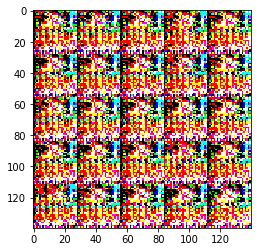

Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.4355
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.6699
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.7972
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.1598
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.2536
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.2965
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 12.6726
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.6611
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.3595
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.2962


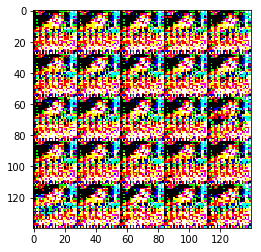

Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.5745
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.5767
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.3920
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.8295
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.4513
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.1532
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 13.1627
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.7561
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 12.1503
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.1513


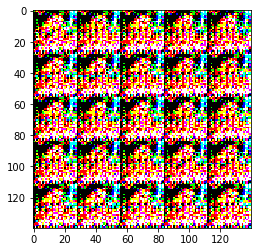

Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.2325
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.3504
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.9616
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.9640
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.6360
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.3726
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.4067
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.7143
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.0783
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.2689


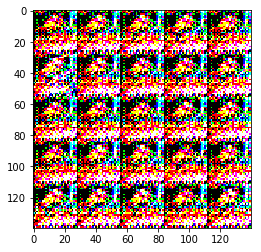

Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.3119
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 15.0414
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 15.0753
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.8185
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.3798
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.3481
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.9663
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.2202
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.0202
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.0802


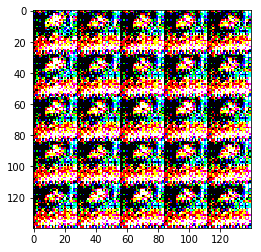

Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.0350
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.8289
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.2752
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.0561
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 14.0784
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.8493
Epoch 1/1... Discriminator Loss: 0.0000... Generator Loss: 13.9802


KeyboardInterrupt: 

In [39]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.